## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
df = data.copy().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [10]:
target = 'survived'

In [11]:
def get_numerical_cols(data: pd.DataFrame) -> list:
    vars_num = []
    for col in data.columns:
        # By using a try/exception block, we can ensure that even quoted
        # numerical columns will be properly identified 
        try:
            data[col] = pd.to_numeric(data[col])
            vars_num.append(col)
        except (ValueError, TypeError):
            # ValueError: Raised when the conversion to numeric fails
            # TypeError: Raised when the column contains non-string values
            pass
    return vars_num

def get_categorical_cols(data: pd.DataFrame) -> list:
    df_cat = data.select_dtypes(include=['object'])
    vars_cat = df_cat.columns.tolist()
    return vars_cat

In [12]:
vars_num = get_numerical_cols(df)
vars_cat = get_categorical_cols(df)

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [13]:
# first in numerical variables
def get_nan_indices(data: pd.DataFrame, selected_cols: list) -> list:
    df_nans = data[data[selected_cols].isna().any(axis=1)]
    idx_nans = df_nans.index.tolist()
    return idx_nans

idx_nans = get_nan_indices(df, vars_num)
df[vars_num].loc[idx_nans]

,pclass,survived,age,sibsp,parch,fare
15,1,0,NaN,0,0,25.9250
37,1,1,NaN,0,0,26.5500
40,1,0,NaN,0,0,39.6000
46,1,0,NaN,0,0,31.0000
59,1,1,NaN,0,0,27.7208
...,...,...,...,...,...,...
1293,3,0,NaN,0,0,8.0500
1297,3,0,NaN,0,0,7.2500
1302,3,0,NaN,0,0,7.2250
1303,3,0,NaN,0,0,14.4583


In [14]:
# now in categorical variables
idx_nans = get_nan_indices(df, vars_cat)
df[vars_cat].loc[idx_nans]

,sex,cabin,embarked,title
9,male,NaN,C,Mr
13,female,NaN,S,Miss
15,male,NaN,S,Mr
23,female,NaN,C,Miss
25,male,NaN,C,Mr
...,...,...,...,...
1304,female,NaN,C,Miss
1305,female,NaN,C,Miss
1306,male,NaN,C,Mr
1307,male,NaN,C,Mr


### Determine cardinality of categorical variables

In [15]:
def get_cardinality(data: pd.DataFrame, categorical_cols: list) -> dict:
    cardinality = {}
    for col in categorical_cols:
        cardinality[col] = len(data[col].dropna().unique())
    return cardinality

In [16]:
cardinality = get_cardinality(data, vars_cat)
for k, val in cardinality.items():
    print(k, val)

sex 2
cabin 181
embarked 3
title 5


### Determine the distribution of numerical variables

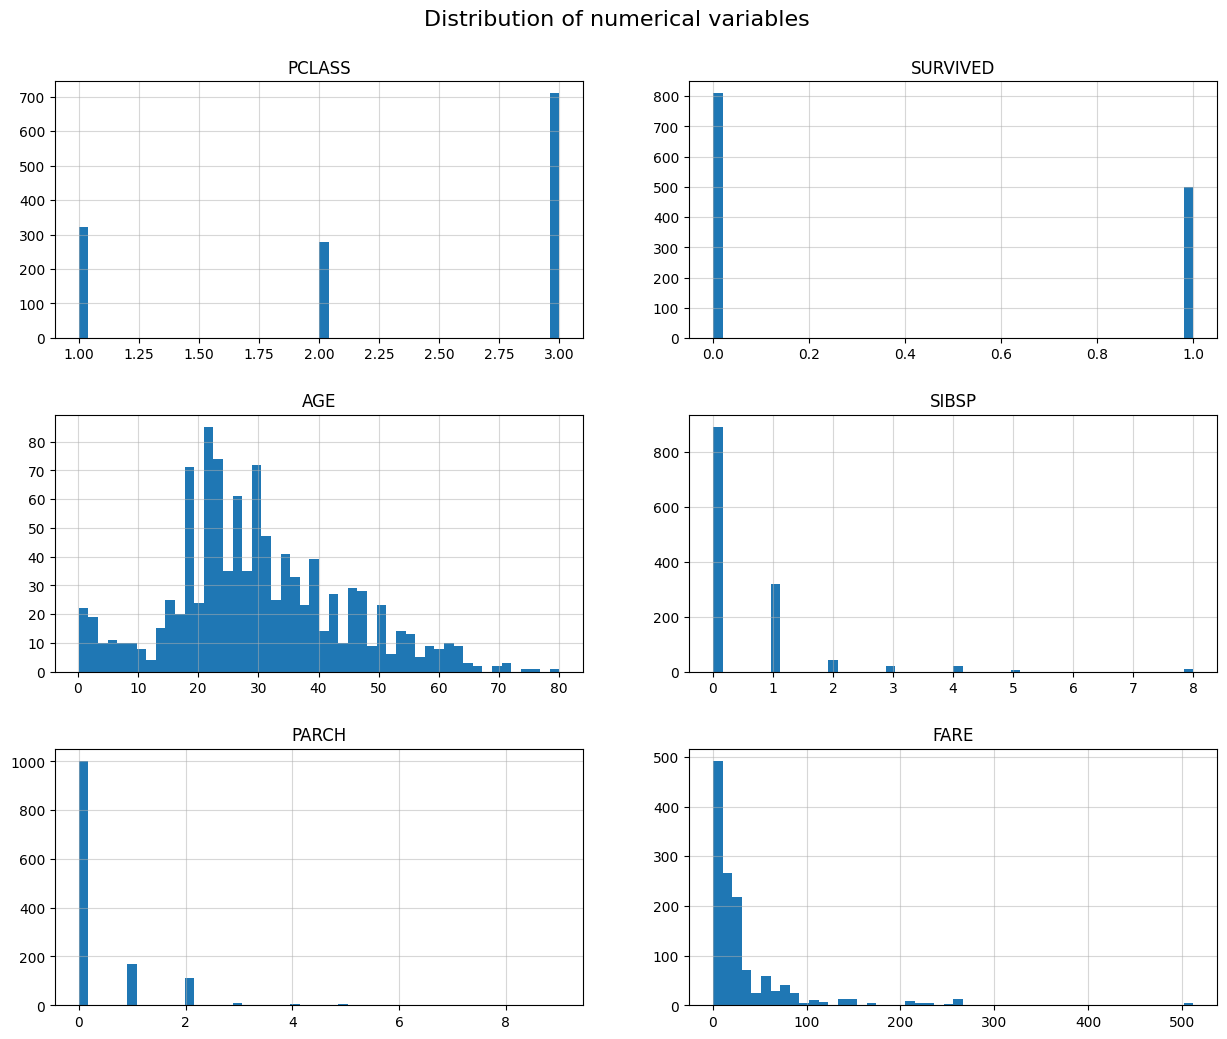

In [17]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("Distribution of numerical variables", fontsize=16, y=0.94)

for n, col in enumerate(vars_num):
    ax = plt.subplot(3, 2, n + 1)
    ax.hist(df[col], bins=50)
    ax.set_title(col.upper())
    ax.set_xlabel("")
    ax.grid(alpha=0.5)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [19]:
# Remove any integers from the string column using a regular expression
X_train['cabin'] = X_train['cabin'].str.replace('\d+', '', regex=True)
X_test['cabin'] = X_test['cabin'].str.replace('\d+', '', regex=True)

print(f"Unique cabins in the training set : {X_train['cabin'].unique()}")
print(f"Unique cabins in the test set : {X_test['cabin'].unique()}")

Unique cabins in the training set : [nan 'E' 'F' 'A' 'C' 'D' 'B' 'T' 'G']
Unique cabins in the test set : [nan 'G' 'E' 'C' 'B' 'A' 'F' 'D']


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [20]:
for var in ['age', 'fare']:

    # Create binary columns to indicate missing values
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    # Replace NaN by the median for the training set
    median = X_train[var].median()

    X_train[var].fillna(median, inplace=True)
    X_test[var].fillna(median, inplace=True)

X_train[['age', 'fare']].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [21]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [22]:
for col in X_train.columns:
    nan_count_train = X_train[col].isna().sum()
    nan_count_test = X_test[col].isna().sum()
    print(f"Nans in {col} = {nan_count_train} (train), {nan_count_test} (test)")

Nans in pclass = 0 (train), 0 (test)
Nans in sex = 0 (train), 0 (test)
Nans in age = 0 (train), 0 (test)
Nans in sibsp = 0 (train), 0 (test)
Nans in parch = 0 (train), 0 (test)
Nans in fare = 0 (train), 0 (test)
Nans in cabin = 0 (train), 0 (test)
Nans in embarked = 0 (train), 0 (test)
Nans in title = 0 (train), 0 (test)
Nans in age_NA = 0 (train), 0 (test)
Nans in fare_NA = 0 (train), 0 (test)


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [23]:
def replace_rare_categories(data: pd.DataFrame, variables: list, threshold: int = 5):
    rare_categories = {}
    for var in variables:
        df_count = data[var].value_counts() / data.shape[0]
        rare_cat_incol = df_count[df_count < threshold/100].index.tolist()
        data[var] = data[var].replace(rare_cat_incol, 'Rare')
        rare_categories[var] = rare_cat_incol 
    return data, rare_categories

In [24]:
X_train, rare_labels = replace_rare_categories(X_train, vars_cat)
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [25]:
X_test = X_test.replace(rare_labels, 'Rare')
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

In [26]:
X_test[X_test["title"] == "Rare"]

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_NA,fare_NA
231,1,male,52.0000,0,0,30.5000,C,S,Rare,0,0
427,2,male,0.6667,1,1,14.5000,Missing,S,Rare,0,0
642,3,male,13.0000,4,2,31.3875,Missing,S,Rare,0,0
678,3,male,6.0000,1,1,15.2458,Missing,C,Rare,0,0
549,2,male,3.0000,1,1,18.7500,Missing,S,Rare,0,0
1103,3,male,2.0000,4,1,39.6875,Missing,S,Rare,0,0
1240,3,male,0.4167,0,1,8.5167,Missing,C,Rare,0,0
45,1,male,45.0000,0,0,26.5500,Rare,S,Rare,0,0
1256,3,male,7.0000,1,1,15.2458,Missing,C,Rare,0,0
1,1,male,0.9167,1,2,151.5500,C,S,Rare,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [27]:
var = 'sex'
pd.get_dummies(X_train[var], prefix=var, drop_first=False).astype(int)

,sex_female,sex_male
1118,0,1
44,1,0
1072,0,1
1130,1,0
574,0,1
...,...,...
763,1,0
835,0,1
1216,1,0
559,1,0


In [28]:
for var in vars_cat:
    df_bin_train = pd.get_dummies(X_train[var], prefix=var, drop_first=True)
    X_train = pd.concat([X_train, df_bin_train.astype(int)], axis=1)
    df_bin_test = pd.get_dummies(X_test[var], prefix=var, drop_first=True)
    # Check if train and test binary datasets have the same number of classes
    if df_bin_test.shape[1] != df_bin_train.shape[1]:
        # Get the set of column names for each DataFrame
        cols_df_train = set(df_bin_train.columns)
        cols_df_test = set(df_bin_test.columns)
        # Find the missing columns
        missing_columns = list(cols_df_train.difference(cols_df_test))
        for mc in missing_columns:
            df_bin_test[mc] = 0
    X_test = pd.concat([X_test, df_bin_test.astype(int)], axis=1)
    
X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 16))

In [29]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [30]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_NA,fare_NA,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,embarked_Rare,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,0,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,0,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,0,1,0,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,0,1,0,0


In [31]:
variables = [c  for c in X_train.columns]
variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_NA',
 'fare_NA',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [32]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[variables]) 

# transform the train and test set
X_train = scaler.transform(X_train[variables])

X_test = scaler.transform(X_test[variables])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [33]:
model = LogisticRegression(C=0.0005, random_state=0)
# model training
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [34]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431723338485316
train accuracy: 0.7125119388729704

test roc-auc: 0.8354012345679012
test accuracy: 0.7022900763358778



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**